In [3]:
### importing libraries

from datetime import datetime,timedelta
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import json
import os
import gc

from lightgbm import LGBMClassifier
import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,accuracy_score,auc,classification_report

## load dataset

In [4]:
df = pd.read_csv('./data/sensing_data_0.5.csv')
df.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,year,month,day,hours,minute,weekday,weeknumber,label_source,rating,stress_label
0,u17,2013-03-28 15:08:00,3664,315,62,65,5,5,9,156,...,2013,3,28,15,8,Thu,12,stress_ema,1,0
1,u17,2013-03-30 16:06:00,4045,18,0,16,9,9,17,237,...,2013,3,30,16,6,Sat,12,stress_ema,2,1
2,u17,2013-04-11 16:53:00,3640,362,15,78,5,5,6,180,...,2013,4,11,16,53,Thu,14,stress_ema,3,1
3,u17,2013-04-14 15:33:00,4014,112,0,22,6,6,6,434,...,2013,4,14,15,33,Sun,14,stress_ema,3,1
4,u17,2013-04-15 14:07:00,3653,269,75,129,11,10,12,377,...,2013,4,15,14,7,Mon,15,stress_ema,3,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455 entries, 0 to 2454
Data columns (total 38 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   user_id                               2455 non-null   object
 1   date_time                             2455 non-null   object
 2   activity_inf_stationary_count         2455 non-null   int64 
 3   activity_inf_walking_count            2455 non-null   int64 
 4   activity_inf_running_count            2455 non-null   int64 
 5   activity_inf_unknown_count            2455 non-null   int64 
 6   app_usage_baseActivity_mClass         2455 non-null   int64 
 7   app_usage_baseActivity_mPackage       2455 non-null   int64 
 8   app_usage_baseActivity_id_count       2455 non-null   int64 
 9   app_usage_baseActivity_numActivities  2455 non-null   int64 
 10  app_usage_baseActivity_numRunning     2455 non-null   int64 
 11  app_usage_topActivity_mClass  

In [6]:
df.describe()

,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,app_usage_baseActivity_numRunning,app_usage_topActivity_mClass,...,phonelock_minutes,phonelock_seconds,year,month,day,hours,minute,weeknumber,rating,stress_label
count,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,...,2455.000000,2455.000000,2455.0,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000
mean,4376.148676,303.131976,77.894501,189.774745,14.379226,13.268024,17.239919,594.028513,343.393483,16.788187,...,194.195112,11674.794297,2013.0,4.224847,15.397963,14.274134,24.409369,15.600815,2.182077,0.291650
std,3530.497803,471.641989,137.610712,421.146866,9.087323,8.148470,10.715056,636.876830,241.768032,10.345968,...,158.246817,9502.244947,0.0,0.664591,9.455342,6.510618,18.665454,2.711081,1.294401,0.454614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2013.0,3.000000,1.000000,0.000000,0.000000,12.000000,1.000000,0.000000
25%,3398.500000,91.000000,1.000000,26.000000,8.000000,8.000000,10.000000,212.000000,144.000000,10.000000,...,68.000000,4113.500000,2013.0,4.000000,7.000000,11.000000,7.000000,13.000000,1.000000,0.000000
50%,3744.000000,186.000000,28.000000,62.000000,13.000000,12.000000,16.000000,436.000000,293.000000,16.000000,...,174.000000,10467.000000,2013.0,4.000000,15.000000,15.000000,22.000000,15.000000,2.000000,0.000000
75%,3971.000000,314.000000,92.500000,159.000000,19.000000,17.000000,22.000000,726.500000,501.000000,22.000000,...,305.000000,18326.500000,2013.0,5.000000,25.000000,19.000000,40.000000,18.000000,3.000000,1.000000
max,20949.000000,5010.000000,2051.000000,6594.000000,62.000000,57.000000,78.000000,4668.000000,1981.000000,73.000000,...,803.000000,48239.000000,2013.0,6.000000,31.000000,23.000000,59.000000,22.000000,5.000000,1.000000


## Dropping columns

In [7]:
df = df.sample(frac= 1,random_state=2022)
df

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,year,month,day,hours,minute,weekday,weeknumber,label_source,rating,stress_label
2391,u33,2013-04-04 23:42:00,3872,191,0,32,46,43,46,4132,...,2013,4,4,23,42,Thu,13,stress_ema,1,0
1383,u27,2013-04-15 21:00:00,3604,203,1,187,11,10,31,372,...,2013,4,15,21,0,Mon,15,stress_ema,1,0
962,u41,2013-04-08 22:47:00,1589,1,0,2,3,3,3,70,...,2013,4,8,22,47,Mon,14,stress_ema,1,0
1063,u39,2013-04-16 23:34:00,3995,62,13,58,6,6,9,168,...,2013,4,16,23,34,Tue,15,stress_ema,1,0
2292,u49,2013-05-16 19:11:00,6924,415,48,43,17,14,17,694,...,2013,5,16,19,11,Thu,19,stress_ema,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713,u08,2013-03-26 19:04:00,0,0,0,0,13,11,20,105,...,2013,3,26,19,4,Tue,12,stress_ema,2,1
624,u36,2013-04-17 01:55:00,3693,247,75,74,13,11,13,554,...,2013,4,17,1,55,Wed,15,stress_ema,2,1
173,u51,2013-04-30 17:06:00,3944,47,118,13,6,6,8,169,...,2013,4,30,17,6,Tue,17,stress_ema,3,1
1244,u10,2013-04-08 21:04:00,3774,182,46,30,9,9,10,422,...,2013,4,8,21,4,Mon,14,stress_ema,5,0


In [8]:
df = df.drop(['user_id','date_time','year','label_source','rating'],axis=1)

df['stress_label'].value_counts()

0    1739
1     716
Name: stress_label, dtype: int64

In [9]:
df['weekday'].value_counts()

Wed    392
Tue    385
Thu    375
Fri    373
Mon    362
Sun    330
Sat    238
Name: weekday, dtype: int64

In [10]:
weekday_map = {"Sat":0,"Sun":1,"Mon":2,"Tue":3,"Wed":4,"Thu":5,"Fri":6}

df['weekday'] = df['weekday'].map(weekday_map)

df['weekday'].value_counts()

4    392
3    385
5    375
6    373
2    362
1    330
0    238
Name: weekday, dtype: int64

In [11]:
df = df.reset_index(drop=True)
df

,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,app_usage_baseActivity_numRunning,app_usage_topActivity_mClass,...,phonelock_hours,phonelock_minutes,phonelock_seconds,month,day,hours,minute,weekday,weeknumber,stress_label
0,3872,191,0,32,46,43,46,4132,794,50,...,2,136,8179,4,4,23,42,5,13,0
1,3604,203,1,187,11,10,31,372,341,14,...,0,0,0,4,15,21,0,2,15,0
2,1589,1,0,2,3,3,3,70,66,5,...,0,0,0,4,8,22,47,2,14,0
3,3995,62,13,58,6,6,9,168,168,6,...,1,86,5173,4,16,23,34,3,15,0
4,6924,415,48,43,17,14,17,694,622,17,...,2,170,10210,5,16,19,11,5,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2450,0,0,0,0,13,11,20,105,99,14,...,0,0,0,3,26,19,4,3,12,1
2451,3693,247,75,74,13,11,13,554,516,15,...,2,170,10232,4,17,1,55,4,15,1
2452,3944,47,118,13,6,6,8,169,169,6,...,7,461,27715,4,30,17,6,3,17,1
2453,3774,182,46,30,9,9,10,422,409,11,...,6,397,23844,4,8,21,4,2,14,0


## Train val split

In [12]:
df_train,df_val,df_test = df[:(len(df)*3)//5],df[(len(df)*3)//5:(len(df)*4)//5],df[(len(df)*4)//5:]

len(df_train),len(df_val),len(df_test)

(1473, 491, 491)

In [13]:
df_train[df_train.columns[-1]]

0       0
1       0
2       0
3       0
4       0
       ..
1468    0
1469    0
1470    0
1471    0
1472    0
Name: stress_label, Length: 1473, dtype: int64

## LGBM

In [14]:
df_train_x,df_train_y = df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]]
df_val_x,df_val_y = df_val[df_val.columns[:-1]], df_val[df_val.columns[-1]]
df_test_x,df_test_y = df_test[df_test.columns[:-1]], df_test[df_test.columns[-1]]

In [15]:
def objective(trial):
  n_estimators_hp = trial.suggest_int('n_estimators', 50, 1000)
  max_depth_hp =  trial.suggest_int('max_depth', 10, 500)
  min_child_samples_hp = trial.suggest_int('min_child_samples', 10, 100)
  num_leaves_hp = trial.suggest_int('num_leaves', 2, 256)
  learning_rate_hp = trial.suggest_loguniform('learning_rate',1e-5,10)
  
  model = LGBMClassifier(n_estimators = n_estimators_hp, 
                         max_depth = max_depth_hp, 
                         min_child_samples = min_child_samples_hp,
                         num_leaves = num_leaves_hp,
                         learning_rate = learning_rate_hp,
                         random_state = 0,is_unbalance=True)
  
  model.fit(df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]])
  
  pred_probs = model.predict_proba(df_val[df_val.columns[:-1]])
  
  return roc_auc_score(df_val[df_val.columns[-1]], pred_probs[:,1])
  #return precision_score(y_test, y_pred)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-11-25 15:14:20,390] A new study created in memory with name: no-name-009ac85d-3ccb-43d9-ac66-622382189375
/tmp/ipykernel_2485372/3744688316.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate_hp = trial.suggest_loguniform('learning_rate',1e-5,10)
[I 2022-11-25 15:14:21,195] Trial 0 finished with value: 0.7184898334934359 and parameters: {'n_estimators': 431, 'max_depth': 289, 'min_child_samples': 24, 'num_leaves': 45, 'learning_rate': 0.0973525371963429}. Best is trial 0 with value: 0.7184898334934359.
/tmp/ipykernel_2485372/3744688316.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate_hp = trial.suggest_log

In [16]:
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print("  Value: {}".format(trial.value))


# Best trial: {'n_estimators': 436, 'max_depth': 133, 'min_child_samples': 12, 'num_leaves': 79, 'learning_rate': 0.011995657090104285}
#   Value: 0.7411743515850144

Best trial: {'n_estimators': 436, 'max_depth': 133, 'min_child_samples': 12, 'num_leaves': 79, 'learning_rate': 0.011995657090104285}
  Value: 0.7411743515850144


In [17]:
# model = LGBMClassifier(**study.best_trial.params, random_state = 0,is_unbalance=True )

model = LGBMClassifier(**{'n_estimators': 436, 'max_depth': 133, 'min_child_samples': 12, 'num_leaves': 79, 'learning_rate': 0.011995657090104285}, random_state = 0,is_unbalance=True )
 
model.fit(df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]])
 
roc_auc_score(df_test[df_test.columns[-1]], model.predict_proba(df_test[df_test.columns[:-1]])[:,1])

0.6715147732001666

In [18]:
fpr, tpr, _ = roc_curve(df_test[df_test.columns[-1]], model.predict_proba(df_test[df_test.columns[:-1]])[:,1])
roc_auc = auc(fpr, tpr)

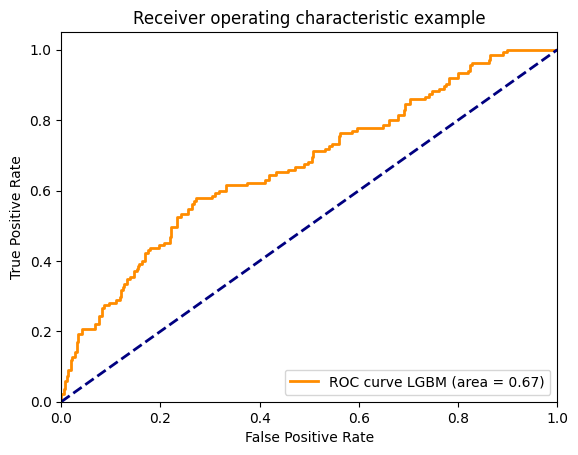

In [19]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve LGBM (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [20]:
print(classification_report(df_test[df_test.columns[-1]], model.predict(df_test[df_test.columns[:-1]])))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       356
           1       0.49      0.36      0.41       135

    accuracy                           0.72       491
   macro avg       0.63      0.61      0.61       491
weighted avg       0.70      0.72      0.71       491



In [21]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,df_train_x.columns),reverse=True), columns=['Value','Feature'])
feature_imp

,Value,Feature
0,2304,minute
1,2168,activity_inf_unknown_count
2,2064,audio_inf_silence_count
3,2045,audio_inf_voice_count
4,1927,day
5,1891,conversation_minutes
6,1877,activity_inf_running_count
7,1794,audio_inf_noise_count
8,1757,activity_inf_stationary_count
9,1724,app_usage_baseActivity_numRunning


## Log reg

In [22]:
df_train_x,df_train_y = df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]]
df_val_x,df_val_y = df_val[df_val.columns[:-1]], df_val[df_val.columns[-1]]
df_test_x,df_test_y = df_test[df_test.columns[:-1]], df_test[df_test.columns[-1]]


df_train_x.shape,df_train_y.shape,df_val_x.shape,df_val_y.shape,df_test_x.shape,df_test_y.shape

((1473, 32), (1473,), (491, 32), (491,), (491, 32), (491,))

In [23]:
sc = StandardScaler()
sc = sc.fit(df_train_x)

df_train_x_sc = sc.transform(df_train_x)
df_val_x_sc = sc.transform(df_val_x)
df_test_x_sc = sc.transform(df_test_x)

In [24]:
def objective(trial):
  c_hp = trial.suggest_float('C', 0.0001, 100)
  
  
  model = LogisticRegression(C = c_hp, 
                         
                         random_state = 0,class_weight="balanced",n_jobs = -1)
  
  model.fit(df_train_x_sc, df_train_y)
  
  pred_probs = model.predict_proba(df_val_x_sc)
  
  return roc_auc_score(df_val_y, pred_probs[:,1])
  #return precision_score(y_test, y_pred)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-11-25 15:15:52,642] A new study created in memory with name: no-name-8ac84df8-25ff-4e4c-82f5-9e83fbe89c68
/home/sidd/anaconda3/envs/ucsd_hw/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2022-11-25 15:15:53,447] Trial 0 finished with value: 0.6632044508485431 and parameters: {'C': 61.11202879893383}. Best is trial 0 with value: 0.6632044508485431.
/home/sidd/anaconda3/envs/ucsd_hw/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIO

In [25]:
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print("  Value: {}".format(trial.value))

# Best trial: {'C': 0.6192091255820088}
#   Value: 0.6671669868715978

Best trial: {'C': 0.6192091255820088}
  Value: 0.6671669868715978


In [26]:
# model = LGBMClassifier(**study.best_trial.params, random_state = 0,is_unbalance=True )

model = LogisticRegression(**{'C': 0.6192091255820088}, random_state = 0,class_weight="balanced",n_jobs = -1)
 
model.fit(df_train_x_sc, df_train_y)
 
roc_auc_score(df_test_y, model.predict_proba(df_test_x_sc)[:,1])

0.6454640033291719

In [27]:
fpr, tpr, _ = roc_curve(df_test_y, model.predict_proba(df_test_x_sc)[:,1])
roc_auc = auc(fpr, tpr)

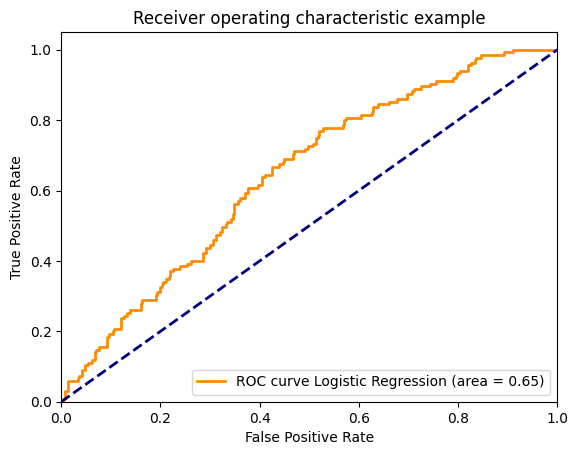

In [28]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve Logistic Regression (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [29]:
print(classification_report(df_test_y, model.predict(df_test_x_sc)))

              precision    recall  f1-score   support

           0       0.81      0.60      0.69       356
           1       0.37      0.63      0.47       135

    accuracy                           0.60       491
   macro avg       0.59      0.61      0.58       491
weighted avg       0.69      0.60      0.63       491



## SVM

In [30]:
def objective(trial):
  c_hp = trial.suggest_float('C', 0.001, 100)
  
  
  model = SVC(C = c_hp, 
                         
                         random_state = 0,class_weight="balanced",probability = True)
  
  model.fit(df_train_x_sc, df_train_y)
  
  pred_probs = model.predict_proba(df_val_x_sc)
  
  return roc_auc_score(df_val_y, pred_probs[:,1])
  #return precision_score(y_test, y_pred)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-11-25 15:16:37,263] A new study created in memory with name: no-name-726f59ed-6a8b-4423-b1b2-792163082334
[I 2022-11-25 15:16:37,678] Trial 0 finished with value: 0.6360770893371758 and parameters: {'C': 34.021714593783194}. Best is trial 0 with value: 0.6360770893371758.
[I 2022-11-25 15:16:38,131] Trial 1 finished with value: 0.6294228306115914 and parameters: {'C': 48.93890158879394}. Best is trial 0 with value: 0.6360770893371758.
[I 2022-11-25 15:16:38,446] Trial 2 finished with value: 0.6387187800192123 and parameters: {'C': 18.832736435722815}. Best is trial 2 with value: 0.6387187800192123.
[I 2022-11-25 15:16:38,836] Trial 3 finished with value: 0.6362972302273455 and parameters: {'C': 33.57209795033793}. Best is trial 2 with value: 0.6387187800192123.
[I 2022-11-25 15:16:39,299] Trial 4 finished with value: 0.6293427793788025 and parameters: {'C': 50.8257211128125}. Best is trial 2 with value: 0.6387187800192123.
[I 2022-11-25 15:16:39,807] Trial 5 finished with value

In [31]:
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print("  Value: {}".format(trial.value))

# Best trial: {'C': 0.24548137460953456}
#   Value: 0.6532380723663145

Best trial: {'C': 0.24548137460953456}
  Value: 0.6532380723663145


In [32]:
# model = LGBMClassifier(**study.best_trial.params, random_state = 0,is_unbalance=True )

model = SVC(**{'C': 0.24548137460953456}, random_state = 0,class_weight="balanced",probability = True)
 
model.fit(df_train_x_sc, df_train_y)
 
roc_auc_score(df_test_y, model.predict_proba(df_test_x_sc)[:,1])

0.6325842696629214

In [33]:
fpr, tpr, _ = roc_curve(df_test_y, model.predict_proba(df_test_x_sc)[:,1])
roc_auc = auc(fpr, tpr)

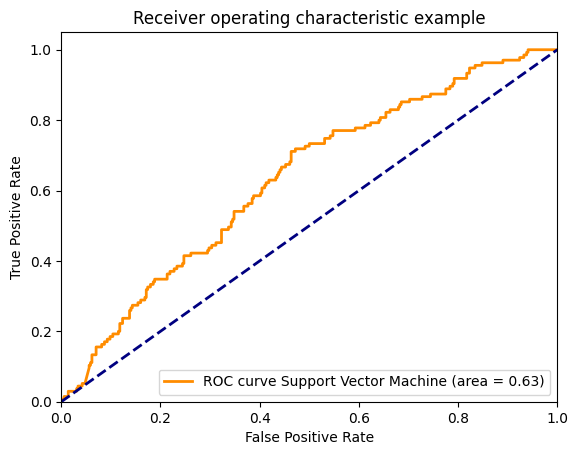

In [34]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve Support Vector Machine (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [35]:
print(classification_report(df_test_y, model.predict(df_test_x_sc)))

              precision    recall  f1-score   support

           0       0.80      0.59      0.68       356
           1       0.36      0.61      0.45       135

    accuracy                           0.59       491
   macro avg       0.58      0.60      0.57       491
weighted avg       0.68      0.59      0.62       491



## Random forest

In [36]:
df_train_x,df_train_y = df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]]
df_val_x,df_val_y = df_val[df_val.columns[:-1]], df_val[df_val.columns[-1]]
df_test_x,df_test_y = df_test[df_test.columns[:-1]], df_test[df_test.columns[-1]]


df_train_x.shape,df_train_y.shape,df_val_x.shape,df_val_y.shape,df_test_x.shape,df_test_y.shape

((1473, 32), (1473,), (491, 32), (491,), (491, 32), (491,))

In [37]:
def objective(trial):
  n_estimators_hp = trial.suggest_int('n_estimators', 50, 1000)
  max_depth_hp =  trial.suggest_int('max_depth', 10, 100)
  min_child_samples_hp = trial.suggest_int('min_samples_split', 10, 100)
  num_leaves_hp = trial.suggest_int('min_samples_leaf', 2, 256)
  
  
  model = RandomForestClassifier(n_estimators = n_estimators_hp, 
                         max_depth = max_depth_hp, 
                         min_samples_split = min_child_samples_hp,
                         min_samples_leaf = num_leaves_hp,
                         
                         random_state = 0,class_weight="balanced",n_jobs = -1)
  
  model.fit(df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]])
  
  pred_probs = model.predict_proba(df_val[df_val.columns[:-1]])
  
  return roc_auc_score(df_val[df_val.columns[-1]], pred_probs[:,1])
  #return precision_score(y_test, y_pred)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-11-25 15:18:02,874] A new study created in memory with name: no-name-81801b19-5d95-4633-80f9-5d5da9727dcb
[I 2022-11-25 15:18:04,227] Trial 0 finished with value: 0.6854987191802755 and parameters: {'n_estimators': 436, 'max_depth': 27, 'min_samples_split': 37, 'min_samples_leaf': 53}. Best is trial 0 with value: 0.6854987191802755.
[I 2022-11-25 15:18:04,629] Trial 1 finished with value: 0.671329650976625 and parameters: {'n_estimators': 106, 'max_depth': 81, 'min_samples_split': 93, 'min_samples_leaf': 106}. Best is trial 0 with value: 0.6854987191802755.
[I 2022-11-25 15:18:04,758] Trial 2 finished with value: 0.6502361511367274 and parameters: {'n_estimators': 55, 'max_depth': 81, 'min_samples_split': 72, 'min_samples_leaf': 112}. Best is trial 0 with value: 0.6854987191802755.
[I 2022-11-25 15:18:06,153] Trial 3 finished with value: 0.6891810758885687 and parameters: {'n_estimators': 353, 'max_depth': 65, 'min_samples_split': 96, 'min_samples_leaf': 25}. Best is trial 3 wi

In [39]:
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print("  Value: {}".format(trial.value))

# Best trial: {'n_estimators': 229, 'max_depth': 99, 'min_samples_split': 10, 'min_samples_leaf': 4}
#   Value: 0.7237632084534101

Best trial: {'n_estimators': 229, 'max_depth': 99, 'min_samples_split': 10, 'min_samples_leaf': 4}
  Value: 0.7237632084534101


In [40]:
# model = LGBMClassifier(**study.best_trial.params, random_state = 0,is_unbalance=True )

model = RandomForestClassifier(**{'n_estimators': 229, 'max_depth': 99, 'min_samples_split': 10, 'min_samples_leaf': 4},random_state = 0 ,class_weight="balanced",n_jobs = -1)
 
model.fit(df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]])
 
roc_auc_score(df_test[df_test.columns[-1]], model.predict_proba(df_test[df_test.columns[:-1]])[:,1])

0.7001872659176029

In [41]:
fpr, tpr, _ = roc_curve(df_test[df_test.columns[-1]], model.predict_proba(df_test[df_test.columns[:-1]])[:,1])
roc_auc = auc(fpr, tpr)

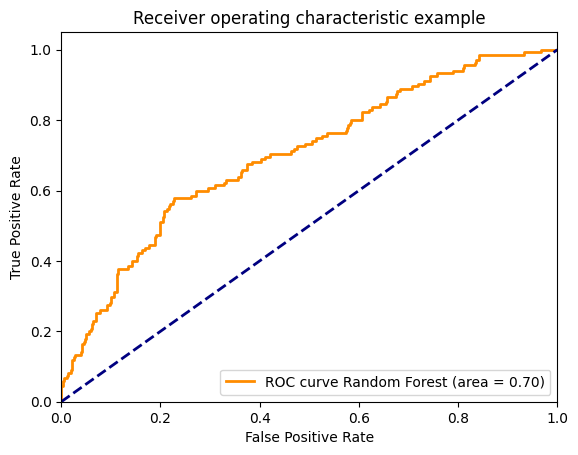

In [42]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve Random Forest (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [43]:
print(classification_report(df_test[df_test.columns[-1]], model.predict(df_test[df_test.columns[:-1]])))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       356
           1       0.50      0.39      0.44       135

    accuracy                           0.73       491
   macro avg       0.65      0.62      0.63       491
weighted avg       0.71      0.73      0.71       491



In [44]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,df_train_x.columns),reverse=True), columns=['Value','Feature'])
feature_imp

,Value,Feature
0,0.062915,activity_inf_unknown_count
1,0.062279,activity_inf_stationary_count
2,0.058352,day
3,0.053724,weeknumber
4,0.045922,audio_inf_silence_count
5,0.045432,app_usage_baseActivity_numRunning
6,0.044055,activity_inf_walking_count
7,0.042985,activity_inf_running_count
8,0.040596,minute
9,0.040303,audio_inf_noise_count


## End